# Python Group 8 Assignment

In [97]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.tools as tls
import plotly.plotly as py
from sklearn.svm import SVR
from sklearn.base import clone
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from scipy.special import boxcox1p
from sklearn.decomposition import PCA
from scipy.stats.mstats import winsorize
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import r2_score as metric_scorer
from sklearn.feature_selection import RFE, SelectFromModel
from scipy.stats import skew, boxcox_normmax, chi2_contingency
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, KBinsDiscretizer, PowerTransformer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit

tls.set_credentials_file(username='federicol', api_key='Xcyt2YoSMyqGKCjGYjMr')

import warnings
warnings.filterwarnings('ignore')

## Setting Key Values

In [98]:
SEED = 1
DATA_PATH = 'https://gist.githubusercontent.com/f-loguercio/f5c10c97fe9afe58f77cd102ca81719b/raw/99fb846b22abc8855de305c2159a57a77c9764cf/bikesharing_hourly.csv'
DATA_PATH2 = 'https://gist.githubusercontent.com/f-loguercio/14ac934fabcca41093a51efef335f8f2/raw/58e00b425c711ac1da2fb75f851f4fc9ce814cfa/bikesharing_daily.csv'
PREC_PATH = 'https://gist.githubusercontent.com/akoury/6fb1897e44aec81cced8843b920bad78/raw/b1161d2c8989d013d6812b224f028587a327c86d/precipitation.csv'
TARGET_VARIABLE = 'cnt'
SPLITS = 5
ESTIMATORS = 50
#For metric, import the required library as metric_scorer
METRIC = 'r2'

## Data Reading and Exploration
Here we read the data, print its first rows and describe its contents

In [99]:
def read_data(input_path):
    return pd.read_csv(input_path, parse_dates=[1])

data = read_data(DATA_PATH)
data_daily = read_data(DATA_PATH2)

data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Add Precipitation Data from the National Climatic Data Center

In [100]:
precipitation = read_data(PREC_PATH)
data = pd.merge(data, precipitation,  how='left', on=['dteday','hr'])
data['precipitation'].fillna(0, inplace=True)
data['precipitation'][data['precipitation'] > 0] = 1
data['precipitation'] = data['precipitation'].astype(int).astype('category')
data.head(10)

data_hourly = data.copy()
data_hourly = data_hourly[data_hourly['dteday'].isin(pd.date_range('2011-01-01','2012-09-30'))]

In [101]:
data.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


We review the data types for each column

In [102]:
data.dtypes

instant                   int64
dteday           datetime64[ns]
season                    int64
yr                        int64
mnth                      int64
hr                        int64
holiday                   int64
weekday                   int64
workingday                int64
weathersit                int64
temp                    float64
atemp                   float64
hum                     float64
windspeed               float64
casual                    int64
registered                int64
cnt                       int64
precipitation          category
dtype: object

We check if there is any missing data

In [103]:
def missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_data(data)

,Total,Percent
precipitation,0,0.0
cnt,0,0.0
dteday,0,0.0
season,0,0.0
yr,0,0.0
mnth,0,0.0
hr,0,0.0
holiday,0,0.0
weekday,0,0.0
workingday,0,0.0


We drop unnecessary columns

In [104]:
def drop_columns(df, cols):
    df.drop(df[cols], axis=1, inplace = True)
    return df

data = drop_columns(data, ['instant','casual'])
data.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,registered,cnt,precipitation
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,13,16,1
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,32,40,1
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,27,32,1
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,10,13,1
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1,1,1


## Converting Columns to their true categorical type
Now fixing the data types of numerical columns that are actually categorical

In [105]:
def convert_to_category(df, cols):
    for i in cols:
        df[i] = df[i].astype('category')
    return df

data = convert_to_category(data, data.iloc[:,1:9])

data.dtypes

dteday           datetime64[ns]
season                 category
yr                     category
mnth                   category
hr                     category
holiday                category
weekday                category
workingday             category
weathersit             category
temp                    float64
atemp                   float64
hum                     float64
windspeed               float64
registered                int64
cnt                       int64
precipitation          category
dtype: object

## Adding Registered Customers Lag

In [106]:
#def add_lag(df, cols, lags):
#     new_cols = []
#     for col in cols:
#         for lag in lags:
#             new_col = df['registered'].shift(-lag).rename(str(col) + '_' + str(lag))
#             new_cols.append(new_col) 
#     df = pd.concat([df, new_cols], axis = 1)
#     return df

# data = add_lag(data, ['registered'], [1,24])
# holdout = add_lag(data, ['registered'], [1,24])

# registered_1 = data['registered'].shift(-1).rename("registered_1")
# registered_24 = data['registered'].shift(-24).rename("registered_24")
# data = pd.concat([data, registered_1, registered_24], axis = 1)

# registered_1 = holdout['registered'].shift(-1).rename("registered_1")
# registered_24 = holdout['registered'].shift(-24).rename("registered_24")
# holdout = pd.concat([holdout, registered_1, registered_24], axis = 1)

# registered_1 = data['registered'].shift(1)
# registered_1 = registered_1.rename("registered_1")
# registered_1[0] = registered_1[25]
# registered_24 = data['registered'].shift(24)
# registered_24[0:24] = data['registered'][0:24] - 0.1
# registered_24 = registered_24.rename("registered_24")

# data = pd.concat([data, registered_24], axis = 1)
# data.head()

# Exploratory Data Analysis

## Overall distribution the target variable

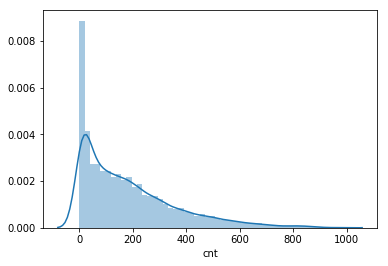

In [11]:
data_hist = [go.Histogram(x=data['cnt'])]

py.iplot(data_hist, filename='basic histogram')

### Usage over time

Text(0, 0.5, 'Users')

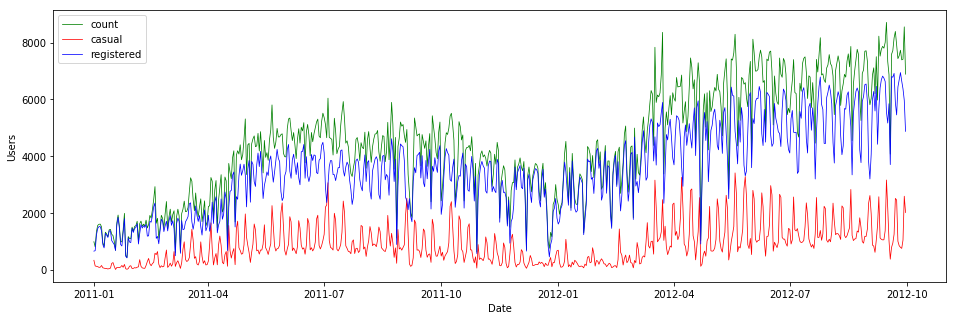

In [30]:
data_daily = data_daily[data_daily['dteday'].isin(pd.date_range('2011-01-01','2012-09-30'))]

data_daily = convert_to_category(data_daily, data_daily.iloc[:,2:9])
data_daily.set_index('dteday')

plt.figure(figsize=(16, 5))

ax = sns.lineplot(data = data_daily, x = 'dteday', y = 'cnt', color='green', size = 1,label = 'count')
ax = sns.lineplot(data = data_daily, x = 'dteday', y = 'casual', color='r', size = 1, label = 'casual')
ax = sns.lineplot(data = data_daily, x = 'dteday', y = 'registered', color='blue', size = 1, label = 'registered')

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:1]+handles[3:4]+handles[6:7], labels[0:1]+labels[3:4]+labels[6:7], loc=2)
plt.xlabel('Date')
plt.ylabel('Users')

### Monthly averages

Text(0, 0.5, 'Users')

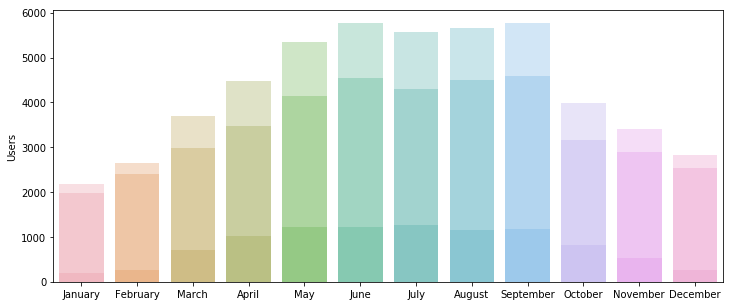

In [31]:
df_month = pd.DataFrame(data_daily.groupby("mnth")[["cnt", 'casual', 'registered']].mean()).reset_index()
months = pd.Series(["January","February","March","April","May","June","July","August","September","October","November","December"]).rename("months")
df_month = pd.concat([df_month, months], axis = 1)


plt.figure(figsize=(12, 5))
ax = sns.barplot(data = df_month, x = "months", y = "cnt", alpha=.3)
ax = sns.barplot(data = df_month, x = "months", y = "casual", alpha=.3)
ax = sns.barplot(data = df_month, x = "months", y = "registered", alpha=.3)

plt.xlabel('')
plt.ylabel('Users')

No considerable differences in trends between casual and registered

### Weekly trend

Text(0, 0.5, 'Users')

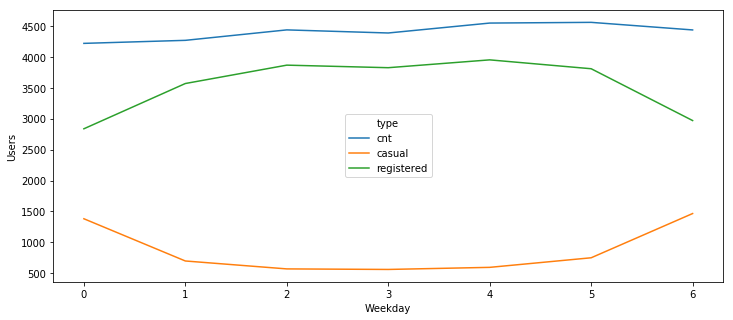

In [32]:
df_week = pd.DataFrame(data_daily.groupby("weekday")[["cnt", 'casual', 'registered']].mean()).reset_index()
df_week = pd.melt(df_week, id_vars = ['weekday'], value_vars = ['cnt', 'casual', 'registered'], var_name = 'type', value_name = 'users')

plt.figure(figsize=(12, 5))
ax = sns.lineplot(data = df_week, x = "weekday", y = "users", hue = "type")
plt.xlabel('Weekday')
plt.ylabel('Users')

Casual and registered users follow exactly opposed trends throughout the week.

### Daily trend

By type of users

Text(0, 0.5, 'Users')

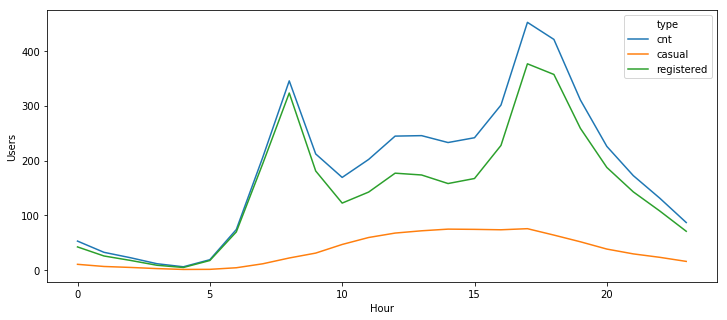

In [33]:
data_hourly = convert_to_category(data_hourly, data_hourly.iloc[:,2:9])
data_hourly.set_index('dteday')


df_day = pd.DataFrame(data_hourly.groupby("hr")[["cnt", 'casual', 'registered']].mean()).reset_index()
df_day = pd.melt(df_day, id_vars = ['hr'], value_vars = ['cnt', 'casual', 'registered'], var_name = 'type', value_name = 'users')

plt.figure(figsize=(12, 5))
sns.lineplot(data = df_day, x = "hr", y = "users", hue = "type")

plt.xlabel('Hour')
plt.ylabel('Users')

By day of the week

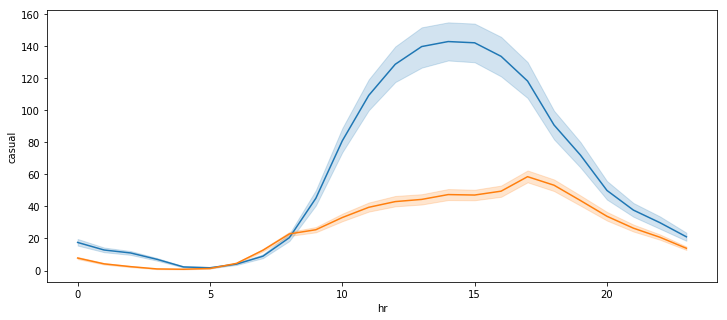

In [34]:
plt.figure(figsize=(12, 5))
sns.lineplot(data = data_hourly.loc[data_hourly['weekday'].isin([0,6])], x = "hr", y = "casual")
sns.lineplot(data = data_hourly.loc[~data_hourly['weekday'].isin([0,6])], x = "hr", y = "casual")

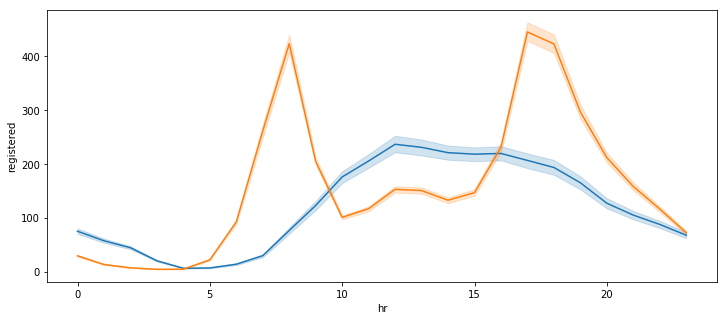

In [35]:
plt.figure(figsize=(12, 5))
sns.lineplot(data = data_hourly.loc[data_hourly['weekday'].isin([0,6])], x = "hr", y = "registered")
sns.lineplot(data = data_hourly.loc[~data_hourly['weekday'].isin([0,6])], x = "hr", y = "registered")

### Temperature has larger effect on casual users

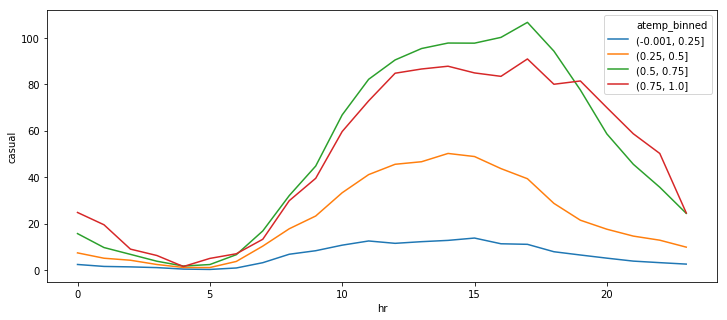

In [36]:
atemp_binned = pd.cut(x = data_hourly['atemp'], bins = 4).rename('atemp_binned')
data_hourly_binned = pd.concat([data_hourly, atemp_binned], axis = 1)

df_day_by_day_atemp = pd.DataFrame(data_hourly_binned.groupby(["hr", "atemp_binned"])[["cnt", 'casual', 'registered']].mean()).reset_index()
df_day_by_day_atemp.head()

plt.figure(figsize=(12, 5))
sns.lineplot(data = df_day_by_day_atemp, x = 'hr', y = 'casual', hue = 'atemp_binned')

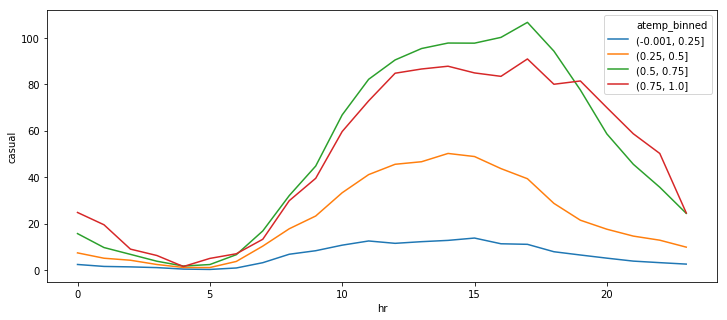

In [37]:
atemp_binned = pd.cut(x = data_hourly['atemp'], bins = 4).rename('atemp_binned')
data_hourly_binned = pd.concat([data_hourly, atemp_binned], axis = 1)

df_day_by_day_atemp = pd.DataFrame(data_hourly_binned.groupby(["hr", "atemp_binned"])[["cnt", 'casual', 'registered']].mean()).reset_index()
df_day_by_day_atemp.head()

plt.figure(figsize=(12, 5))
sns.lineplot(data = df_day_by_day_atemp, x = 'hr', y = 'casual', hue = 'atemp_binned')

### Than on registered users

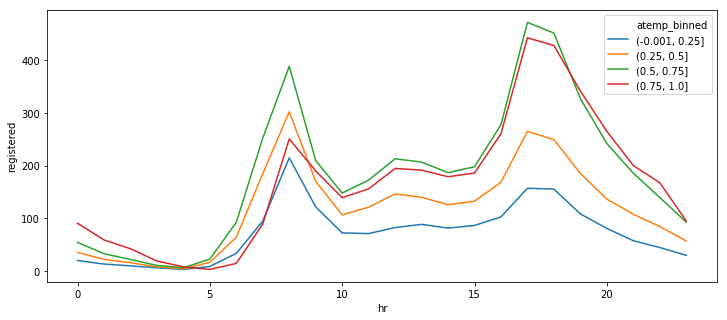

In [38]:
plt.figure(figsize=(12, 5))
sns.lineplot(data = df_day_by_day_atemp, x = 'hr', y = 'registered', hue = 'atemp_binned')

### Does temperature affect usage differently on working days?

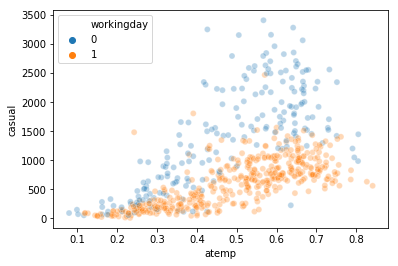

In [39]:
sns.scatterplot(data = data_daily, x = 'atemp', y = 'casual', hue = 'workingday', alpha = .3)

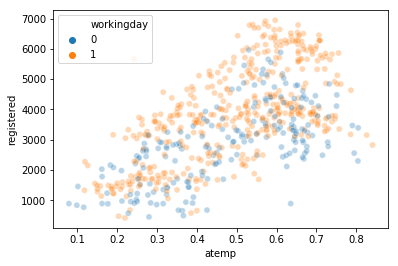

In [40]:
sns.scatterplot(data = data_daily, x = 'atemp', y = 'registered', hue = 'workingday', alpha = .3)

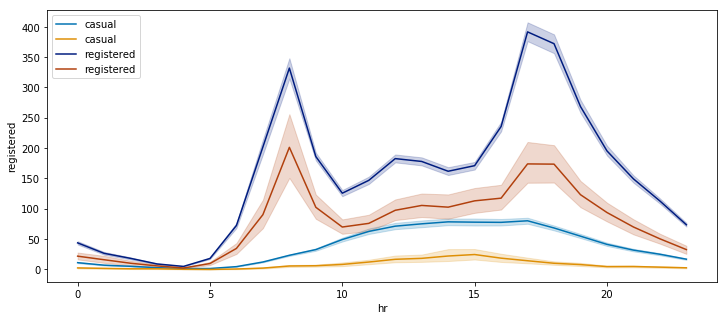

In [41]:
plt.figure(figsize=(12, 5))
ax = sns.lineplot(data = data_hourly, x = "hr", y = "casual", hue = 'precipitation', palette = 'colorblind', label = 'casual')
ax = sns.lineplot(data = data_hourly, x = "hr", y = "registered", hue = 'precipitation', palette = "dark", label = 'registered')

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2]+handles[5:7], labels[0:2]+labels[5:7], loc=2)

### Overall distribution of target variable

In [141]:
data_hist = [go.Histogram(x=data['cnt'])]

py.iplot(data_hist, filename='basic histogram')

In [ ]:
trace = go.Scatter(
    x = data['atemp'],
    y = data['windspeed'],
    mode = 'markers'
)

layout = go.Layout(
    autosize=False,
    width=400,
    height=400,
    yaxis=go.layout.YAxis(
        title='windspeed'
    ),
    xaxis=go.layout.XAxis(
        title='temperature'
    )
)

trace = [trace]

fig = go.Figure(data=trace, layout=layout)

py.iplot(fig, filename='basic-scatter')

In [ ]:
trace = go.Scatter(
    x = data['hr'],
    y = data['hum'],
    mode = 'markers'
)

layout = go.Layout(
    autosize=False,
    width=400,
    height=400,
    yaxis=go.layout.YAxis(
        title='humidity'
    ),
    xaxis=go.layout.XAxis(
        title='hour'
    )
)

trace = [trace]

fig = go.Figure(data=trace, layout=layout)

py.iplot(fig, filename='scatter_hr_hum')

In [ ]:
trace = go.Scatter(
    x = data['hr'],
    y = data['cnt']-data['registered'],
    mode = 'markers'
)

layout = go.Layout(
    autosize=False,
    width=400,
    height=400,
    yaxis=go.layout.YAxis(
        title='casual users'
    ),
    xaxis=go.layout.XAxis(
        title='hour'
    )
)

trace = [trace]

fig = go.Figure(data=trace, layout=layout)

py.iplot(fig, filename='scatter_casual_hr')

In [ ]:
trace = go.Scatter(
    x = data['hr'],
    y = data['registered'],
    mode = 'markers'
)

layout = go.Layout(
    autosize=False,
    width=400,
    height=400,
    yaxis=go.layout.YAxis(
        title='registered users'
    ),
    xaxis=go.layout.XAxis(
        title='hour'
    )
)

trace = [trace]

fig = go.Figure(data=trace, layout=layout)

py.iplot(fig, filename='scatter_casual_hr')

## Extracting Day Variable

In [107]:
def extract_day(df):
    df['day'] = df['dteday'].dt.day
    df = convert_to_category(df, ['day'])
    return df

data = extract_day(data)
data.head(10)

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,registered,cnt,precipitation,day
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,13,16,1,1
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,32,40,1,1
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,27,32,1,1
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,10,13,1,1
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,1,1,1,1
5,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,1,1,1,1
6,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,0,2,0,1
7,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,2,3,0,1
8,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,7,8,1,1
9,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,6,14,1,1


In [108]:
training_data = data[data['dteday'].isin(pd.date_range('2011-01-01','2012-09-30'))].copy()

## Data Correlation
Now we will look at correlation, both numerical and categorical and plot them

In [109]:
def numerical_correlated(df, threshold=0.9):
    corr_matrix = np.absolute(df.select_dtypes(include=[np.number]).corr(method='spearman')).abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    return [column for column in upper.columns if any(abs(upper[column]) > threshold)], corr_matrix

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1), (rcorr-1)))

def categorical_correlated(df, threshold=0.9):
    columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
    corr = pd.DataFrame(index=columns, columns=columns)
    for i in range(0, len(columns)):
        for j in range(i, len(columns)):
            if i == j:
                corr[columns[i]][columns[j]] = 1.0
            else:
                cell = cramers_v(df[columns[i]], df[columns[j]])
                corr[columns[i]][columns[j]] = cell
                corr[columns[j]][columns[i]] = cell
    corr.fillna(value=np.nan, inplace=True)
    upper = corr.where(
    np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    return [column for column in upper.columns if any(abs(upper[column]) > threshold)], corr


def correlated(df, threshold=0.9):
    return (categorical_correlated(df, threshold), numerical_correlated(df, threshold))

correlated_cols = correlated(training_data, 0.85)

if(len(correlated_cols[0][0]) + len(correlated_cols[1][0]) > 0):
    print('The following columns are correlated: ' + str(correlated_cols[0][0] + correlated_cols[1][0]))
else:
    print('No correlated columns for the selected threshold')

The following columns are correlated: ['mnth', 'workingday', 'atemp', 'cnt']


Plot the categorical columns

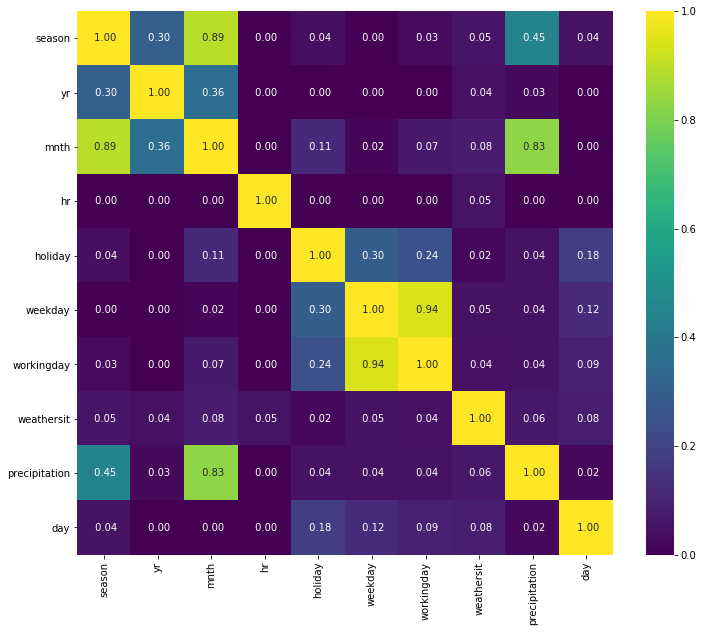

In [50]:
plt.figure(figsize=(12,10))
sns.heatmap(correlated_cols[0][1],cbar=True,fmt =' .2f', annot=True, cmap='viridis')

Plot the numerical columns

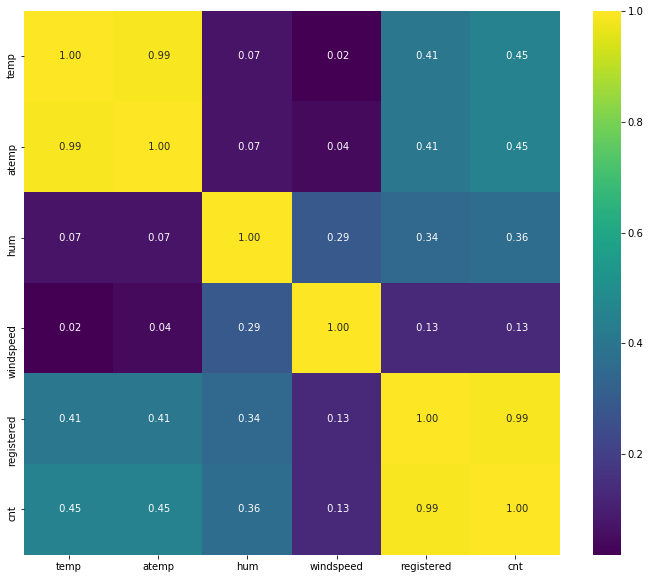

In [51]:
plt.figure(figsize=(12,10))
sns.heatmap(correlated_cols[1][1],cbar=True,fmt =' .2f', annot=True, cmap='viridis')

## Dropping Selected Correlated Columns

In [110]:
data = drop_columns(data, ['mnth', 'workingday', 'atemp', 'registered'])
data.head()

,dteday,season,yr,hr,holiday,weekday,weathersit,temp,hum,windspeed,cnt,precipitation,day
0,2011-01-01,1,0,0,0,6,1,0.24,0.81,0.0,16,1,1
1,2011-01-01,1,0,1,0,6,1,0.22,0.80,0.0,40,1,1
2,2011-01-01,1,0,2,0,6,1,0.22,0.80,0.0,32,1,1
3,2011-01-01,1,0,3,0,6,1,0.24,0.75,0.0,13,1,1
4,2011-01-01,1,0,4,0,6,1,0.24,0.75,0.0,1,1,1


## Outlier Winsorizing
Now we will winsorize outliers

In [111]:
def winsorize_data(df, train_df, cols):
    for col in cols:
        train_df[col] = winsorize(train_df[col], limits = [0.01, 0.01])
        df[df[col] > max(train_df[col])][col] = max(train_df[col])
        df[df[col] < min(train_df[col])][col] = min(train_df[col])
    return df

# data = winsorize_data(data, training_data, data.iloc[:,7:10])

data.describe()

,temp,hum,windspeed,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000
mean,0.496987,0.627229,0.190098,189.463088
std,0.192556,0.192930,0.122340,181.387599
min,0.020000,0.000000,0.000000,1.000000
25%,0.340000,0.480000,0.104500,40.000000
50%,0.500000,0.630000,0.194000,142.000000
75%,0.660000,0.780000,0.253700,281.000000
max,1.000000,1.000000,0.850700,977.000000


## Fixing Data Skewness and Standardizing
Now we will fix skewness if present and standardize numerical features

In [112]:
training_data = data[data['dteday'].isin(pd.date_range('2011-01-01','2012-09-30'))].copy()
pt = PowerTransformer(method='yeo-johnson', standardize = True).fit(training_data.iloc[:,7:10])
data.iloc[:,7:10] = pt.transform(data.iloc[:,7:10])
data.head()

,dteday,season,yr,hr,holiday,weekday,weathersit,temp,hum,windspeed,cnt,precipitation,day
0,2011-01-01,1,0,0,0,6,1,-1.371114,0.945987,-1.781706,16,1,1
1,2011-01-01,1,0,1,0,6,1,-1.464925,0.893007,-1.781706,40,1,1
2,2011-01-01,1,0,2,0,6,1,-1.464925,0.893007,-1.781706,32,1,1
3,2011-01-01,1,0,3,0,6,1,-1.371114,0.629503,-1.781706,13,1,1
4,2011-01-01,1,0,4,0,6,1,-1.371114,0.629503,-1.781706,1,1,1


In [113]:
data.describe()

,temp,hum,windspeed,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000
mean,-0.081235,0.011205,-0.012151,189.463088
std,0.982689,0.986315,1.001682,181.387599
min,-2.365250,-3.007508,-1.781706,1.000000
25%,-0.892262,-0.751340,-0.680979,40.000000
50%,-0.093452,0.006822,0.116538,142.000000
75%,0.743383,0.787325,0.588581,281.000000
max,2.638609,1.969779,3.706122,977.000000


### One Hot Encoding
Hot encoding categorical columns

In [114]:
def one_hot_encode(df, cols):
    initialColumns = set(df)
    
    for i in cols:
        dummies = pd.get_dummies(df[i], prefix=i, drop_first = True)
        df = pd.concat([df, dummies], axis = 1)
        df = df.drop(i, axis = 1)
    
    df = convert_to_category(df, set(df) - initialColumns)
    return df

data = one_hot_encode(data, data.iloc[:,np.r_[:,1:5,6,11:13]])

data.head()

,dteday,weekday,temp,hum,windspeed,cnt,season_2,season_3,season_4,yr_1,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
0,2011-01-01,6,-1.371114,0.945987,-1.781706,16,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2011-01-01,6,-1.464925,0.893007,-1.781706,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2011-01-01,6,-1.464925,0.893007,-1.781706,32,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2011-01-01,6,-1.371114,0.629503,-1.781706,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2011-01-01,6,-1.371114,0.629503,-1.781706,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Creating Holdout Set for Final Validation

In [115]:
holdout = data[data['dteday'].isin(pd.date_range('2012-10-01','2012-12-31'))].copy()
holdout_final_plots = holdout.copy() # will need this for plots at the end
holdout = drop_columns(holdout, ['dteday'])
data = data[data['dteday'].isin(pd.date_range('2011-01-01','2012-09-30'))]
data = drop_columns(data, ['dteday'])

## Underrepresented Features
Now we will see underrepresented features

In [61]:
def under_represented_features(df, threshold = 0.99):
    under_rep = []
    for column in df:
        counts = df[column].value_counts()
        majority_freq = counts.iloc[0]
        if (majority_freq / len(df)) > threshold:
            under_rep.append(column)
    return under_rep

under_represented = under_represented_features(data.loc[:, data.columns != TARGET_VARIABLE])

if not under_represented:
    print('No underrepresented features')
else:
    print(str(under_represented) + ' are underrepresented')
    data = drop_columns(data, under_represented)
    holdout = drop_columns(holdout, under_represented)
    
data.head()

['weathersit_4'] are underrepresented


,weekday,temp,hum,windspeed,cnt,season_2,season_3,season_4,yr_1,hr_1,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
0,6,-1.371114,0.945987,-1.781706,16,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6,-1.464925,0.893007,-1.781706,40,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,6,-1.464925,0.893007,-1.781706,32,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,-1.371114,0.629503,-1.781706,13,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6,-1.371114,0.629503,-1.781706,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Cross Validation
Now we will perform cross validation

In [62]:
def cv_evaluate(df, splits = 10, model = None, transformers = None, grid = None):
    folds = TimeSeriesSplit(n_splits = splits)
    X = df.loc[:, df.columns != TARGET_VARIABLE]
    y = df.loc[:, TARGET_VARIABLE]
    train_size = int(len(df) * 0.85)
    X_train, X_validate, y_train, y_validate = X[0:train_size], X[train_size:len(df)], y[0:train_size], y[train_size:len(df)]
    if model is None:
        model = make_pipeline(LinearRegression())

    if transformers:
        model = make_pipeline(model)
        for ind,i in enumerate(transformers):
            model.steps.insert(ind,[str(ind+1),i])

    if grid:
        model = GridSearchCV(model, grid, scoring = METRIC, cv= folds, refit=True, return_train_score = False, error_score=0.0)
        model.fit(X_train, y_train)
        scores = model.cv_results_['mean_test_score']
    else:
        scores = cross_val_score(model, X_train, y_train, scoring = METRIC, cv = folds)
        model.fit(X_train, y_train)

    pred = model.predict(X_validate)
    final_score = metric_scorer(y_validate, pred)
    
    return final_score, scores, model

## Feature Selection
Now we will do feature selection to determine which features to keep

Feature ranking:


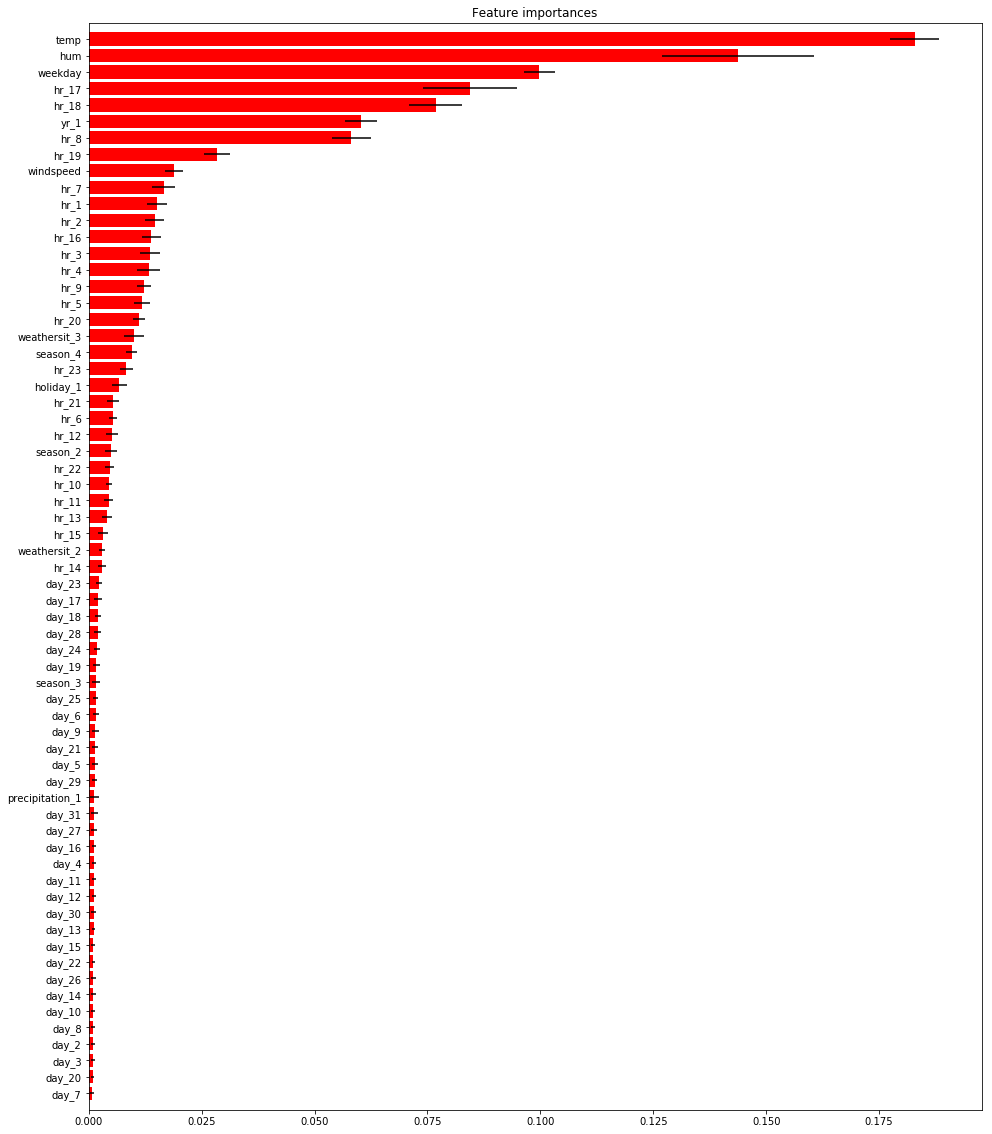

[33, 27, 12, 16, 11, 10, 23, 9, 8, 14, 3, 26, 15, 7, 25, 24, 0, 2, 1, 4]

In [63]:
def feature_importance(df, ratio = 0.01, plot = False):
    forest = RandomForestRegressor(n_estimators=ESTIMATORS, random_state = SEED)
    acc, scores, forest = cv_evaluate(df, model = forest)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
    indices = np.argsort(importances)
    
    if plot:
        X = df.loc[:, df.columns != TARGET_VARIABLE]
        print("Feature ranking:")
        plt.figure(figsize=(16, 20))
        plt.title("Feature importances")
        plt.barh(range(X.shape[1]), importances[indices],color="r", xerr=std[indices], align="center")
        plt.yticks(range(X.shape[1]), [list(df.loc[:, df.columns != TARGET_VARIABLE])[i] for i in indices])
        plt.ylim([-1, X.shape[1]])
        plt.show()
    
    
    keep = [x for x in indices if importances[x] > ratio]
    target = df.columns.get_loc(TARGET_VARIABLE)
    if target not in keep:
        keep.append(target)
        
    return keep

feature_importance(data, plot = True)

## Principal Component Analysis (PCA)
We will plot PCA component variance

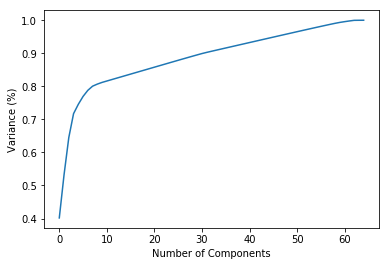

3

In [64]:
def plot_pca_components(df, variance = 0.9):
    X = df.loc[:, df.columns != TARGET_VARIABLE]
    y = df.loc[:, TARGET_VARIABLE]
    pca = PCA()
    X = pca.fit_transform(X)
    pca = PCA().fit(X)

    plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Variance (%)')
    plt.show()
    
    count = 0
    
    for ind, i in enumerate(np.cumsum(pca.explained_variance_ratio_)):
        if count < variance:
            count += i
        else:
            return ind + 1
        
plot_pca_components(data)

## Pipeline
The feature engineering pipeline will decide which functions to keep and which not to based on if they improve the score

In [65]:
def feature_engineering_pipeline(df, models, transformers):
    selected_transformers = []
    
    base_score, base_scores, base_model = cv_evaluate(df, splits = SPLITS)
    top_model = models[0]
    best_score = 0
    all_scores  = pd.DataFrame(columns = ['Model', 'Function', 'CV Score', 'Holdout Score', 'Difference', 'Outcome'])
    all_scores = all_scores.append({'Model': 'base linear_regression', 'Function':'base_score','CV Score': '{:.2f} +/- {:.02}'.format(np.mean(base_scores[base_scores > 0.0]),np.std(base_scores[base_scores > 0.0])),'Holdout Score': base_score, 'Difference': 0, 'Outcome': 'Base'}, ignore_index=True)
    
    for model in models:
        top_score = base_score
        for transformer in transformers:
            engineered_data = df.copy()
            outcome = 'Rejected'
            
            try:
                transformer_score, scores, cv_model = cv_evaluate(engineered_data, model = model[1], transformers = [transformer[1]], splits = SPLITS)
                difference = (transformer_score - top_score)

                if difference > 0:
                    selected_transformers.append((model[0], transformer[1]))
                    top_score = transformer_score
                    outcome = 'Accepted'
                    
                    if transformer_score > best_score:
                        best_score = transformer_score
                        top_model = model

                score = {'Model': model[0], 'Function':transformer[0],'CV Score': '{:.2f} +/- {:.02}'.format(np.mean(scores[scores > 0.0]),np.std(scores[scores > 0.0])),'Holdout Score': transformer_score, 'Difference': difference, 'Outcome': outcome}

            except: 
                score = {'Model': model[0], 'Function':transformer[0],'CV Score': '0','Holdout Score': 0, 'Difference': 0, 'Outcome': 'Error'}
        
            all_scores = all_scores.append(score, ignore_index=True)

    return top_model, [t[1] for t in selected_transformers if t[0] == top_model[0]], all_scores

## Running the Pipeline
Here we will run the pipeline

In [66]:
# models = [
# #     ('linear_regression', LinearRegression()),
#     ('random_forest', RandomForestRegressor(n_estimators=ESTIMATORS, random_state = SEED)),
# #     ('adaboost', AdaBoostRegressor()),
# #     ('gradient_boosting', GradientBoostingRegressor(random_state=SEED)),
# #     ('support_vector', SVR(kernel='rbf', C=1e3, gamma=0.1))
# ]

# transformers = [
#     ('rfe', RFE(LinearRegression())),
#     ('feature_selection', SelectFromModel(LinearRegression())),
#     ('binning', KBinsDiscretizer(n_bins=5, encode='onehot')),
#     ('polynomial', PolynomialFeatures(degree=2, include_bias=False)),
#     ('pca', PCA(.95))
# ]

# top_we_model, final_we_transformers, all_we_scores = feature_engineering_pipeline(data.loc[data['weekday'].isin([0,6])], models, transformers)

# top_wd_model, final_wd_transformers, all_wd_scores = feature_engineering_pipeline(data.loc[~data['weekday'].isin([0,6])], models, transformers)

In [67]:
# grid = {
#     "criterion": ["mse", "mae"],
#     "min_samples_split": [10, 20, 40],
#     "max_depth": [2, 6, 8],
#     "min_samples_leaf": [20, 40, 100],
#     "max_leaf_nodes": [5, 20, 100],
# }

# if len(final_we_transformers) > 0:
#     we_holdout_score, we_scores, we_model = cv_evaluate(data, model = clone(top_we_model[1]), splits = SPLITS, transformers = final_we_transformers, grid = grid)
# else:
#     we_holdout_score, we_scores, we_model = cv_evaluate(data, model = clone(top_we_model[1]), splits = SPLITS, grid = grid)
# score = {'Model': top_we_model[0], 'Function': 'cross_evaluate','CV Score': '{:.3f} +/- {:.02}'.format(np.mean(we_scores[we_scores > 0.0]),np.std(we_scores[we_scores > 0.0])), 'Holdout Score': "{0:.3f}".format(we_holdout_score), 'Difference': 0, 'Outcome': 'Final Cross Validation'}
# all_we_scores = all_we_scores.append(score, ignore_index=True)


# if len(final_wd_transformers) > 0:
#     wd_holdout_score, wd_scores, wd_model = cv_evaluate(data, model = clone(top_wd_model[1]), splits = SPLITS, transformers = final_wd_transformers, grid = grid)
# else:
#     wd_holdout_score, wd_scores, wd_model = cv_evaluate(data, model = clone(top_wd_model[1]), splits = SPLITS, grid = grid)
    
# score = {'Model': top_wd_model[0], 'Function': 'cross_evaluate','CV Score': '{:.3f} +/- {:.02}'.format(np.mean(wd_scores[wd_scores > 0.0]),np.std(wd_scores[wd_scores > 0.0])), 'Holdout Score': "{0:.3f}".format(wd_holdout_score), 'Difference': 0, 'Outcome': 'Final Cross Validation'}
# all_wd_scores = all_wd_scores.append(score, ignore_index=True)

## Scores
Here you can see all of the scores

In [68]:
# all_we_scores

In [69]:
# all_wd_scores

In [70]:
we_model = make_pipeline(RFE(RandomForestRegressor(n_estimators=ESTIMATORS, random_state = SEED)),SelectFromModel(RandomForestRegressor(n_estimators=ESTIMATORS, random_state = SEED)),RandomForestRegressor(n_estimators=ESTIMATORS, random_state = SEED))
wd_model = make_pipeline(RFE(RandomForestRegressor(n_estimators=ESTIMATORS, random_state = SEED)),PolynomialFeatures(degree=2, include_bias=False),RandomForestRegressor(n_estimators=ESTIMATORS, random_state = SEED))

In [71]:
#This should be uncommented when you run GridSearch
# print(we_model.best_params_)
# print(wd_model.best_params_)
# final_we_model = we_model.best_estimator_
# final_wd_model = wd_model.best_estimator_
#Remove this after
final_we_model = we_model
final_wd_model = wd_model

# Final Score
This is the final score of the model

In [72]:
def predict(df, holdout_df, model):
    X_train = df.loc[:, df.columns != TARGET_VARIABLE]
    y_train = df.loc[:, TARGET_VARIABLE]
    model.fit(X_train, y_train)
    
    X = holdout_df.loc[:, holdout_df.columns != TARGET_VARIABLE]
    y = holdout_df.loc[:, TARGET_VARIABLE]
    pred = pd.DataFrame(model.predict(X), columns = ['pred'])
    return pred.set_index(y.index)

data['index1'] = data.index
holdout['index1'] = holdout.index

y_we_preds = predict(data.loc[data['weekday'].isin([0,6])], holdout.loc[holdout['weekday'].isin([0,6])], final_we_model)
y_wd_preds = predict(data.loc[~data['weekday'].isin([0,6])], holdout.loc[~holdout['weekday'].isin([0,6])], final_wd_model)

final_holdout = pd.merge(holdout, y_we_preds,how = 'left',left_index = True, right_index = True, suffixes=('',''))
final_holdout.loc[~holdout['weekday'].isin([0,6]), 'pred'] = y_wd_preds

y = holdout.loc[:, TARGET_VARIABLE]
pred = final_holdout['pred']
score = metric_scorer(y, pred)
print(score)

0.6679112952209091


## Plot of Predictions

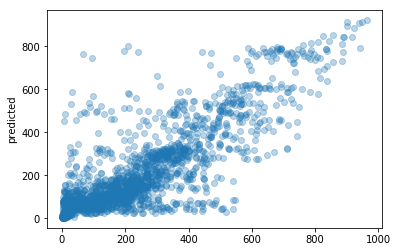

In [116]:
plt.scatter(y, pred, alpha=0.3)
plt.ylabel('predicted')
plt.show()

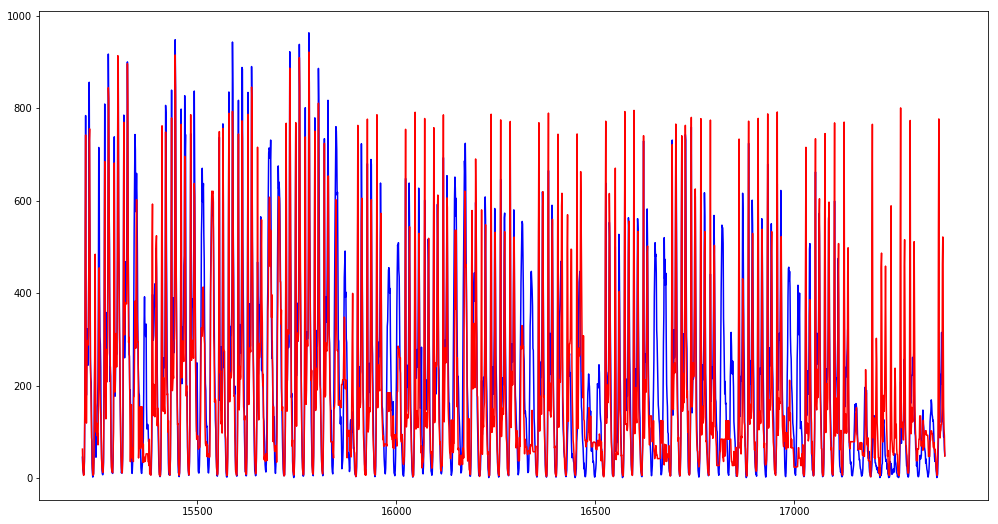

In [117]:
plt.figure(figsize=(17, 9))
sns.lineplot(data = y, color='blue')
sns.lineplot(data = pred, color='red')

In [118]:
holdout_final_plots['pred'] = pred

Text(0, 0.5, 'Users')

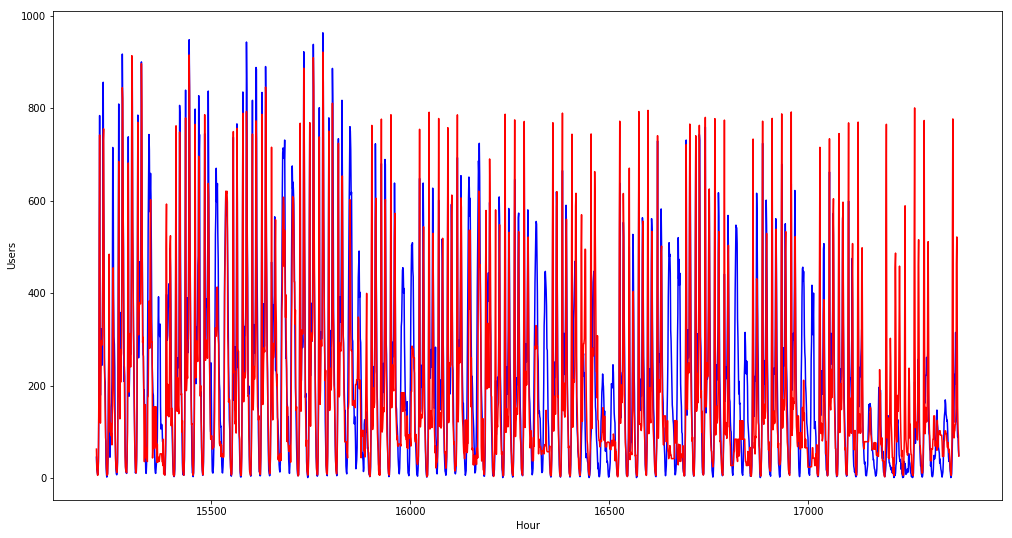

In [119]:
plt.figure(figsize=(17, 9))
ax = sns.lineplot(data = y, color='blue')
ax = sns.lineplot(data = pred, color='red')
plt.xlabel('Hour')
plt.ylabel('Users')

Text(0, 0.5, 'Users')

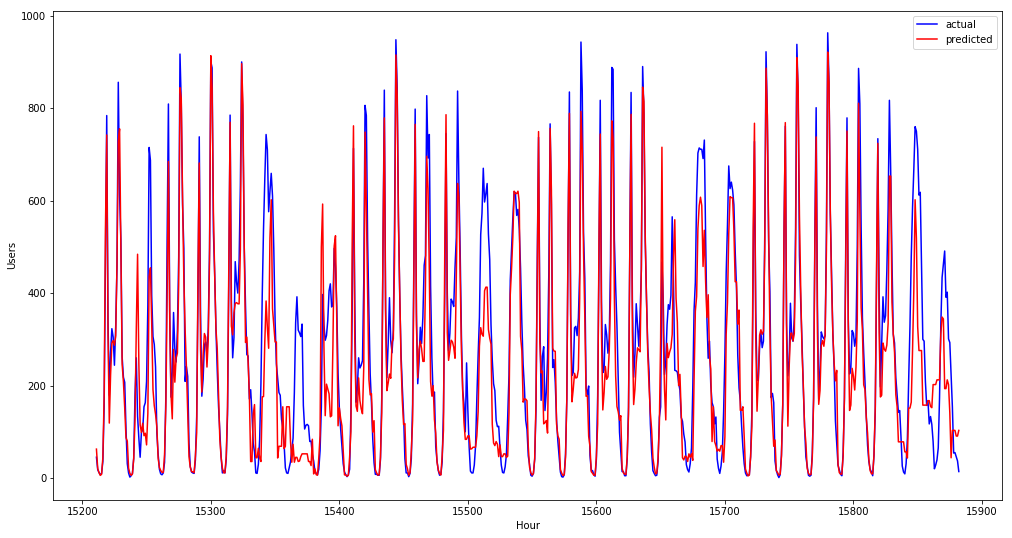

In [124]:
plt.figure(figsize=(17, 9))
ax = sns.lineplot(data = y[0:672], color='blue', label = 'actual')
ax = sns.lineplot(data = pred[0:672], color='red', label = 'predicted')

plt.xlabel('Hour')
plt.ylabel('Users')

In [121]:
holdout_daily = pd.DataFrame(holdout_final_plots.groupby(["dteday"])[["pred", 'cnt']].sum()).reset_index()

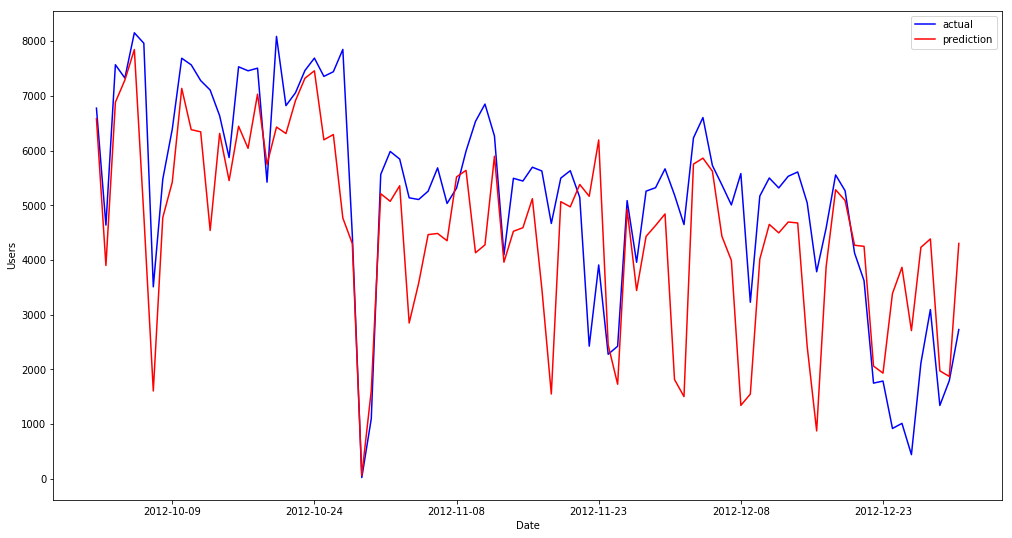

In [122]:
ax = plt.figure(figsize=(17, 9))
ax = sns.lineplot(data = holdout_daily, x = 'dteday', y = 'cnt', color='blue', label = 'actual')
ax = sns.lineplot(data = holdout_daily, x = 'dteday', y = 'pred', color='red', label = 'prediction')
plt.xlabel('Date')
plt.ylabel('Users')
ax.xaxis.set_major_locator(plt.MaxNLocator(8))